In [1]:
# === Imports and paths ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe  # contorno de texto

OPT_GLOB   = "optimal_ilr_by_country_all_scenarios.csv"    # Table of optimal ILRs by scenario
ENERGY_CSV = "all_cities_all_ILR_energy.csv"               # Table with AC_energy_MWh by City×ILR

In [3]:
# === Helpers ===

def load_latest_optimal(path_glob=OPT_GLOB) -> pd.DataFrame:
    files = sorted(glob.glob(path_glob), key=os.path.getmtime)
    if not files:
        raise FileNotFoundError(f"No hay archivos que coincidan con {path_glob}")
    df = pd.read_csv(files[-1])
    need = {"Country","City","ILR","npv_over_I","ppa_eur_mwh","module_factor"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"Faltan columnas en optimal_table: {sorted(miss)}")
    return df

def filter_scenario(df_opt: pd.DataFrame, ppa: float, module_factor: float) -> pd.DataFrame:
    sub = (df_opt.query("ppa_eur_mwh == @ppa and module_factor == @module_factor")
                .copy()
                .reset_index(drop=True))
    if sub.empty:
        raise ValueError(f"Escenario vacío (ppa={ppa}, module_factor={module_factor})")
    return sub

def load_energy(energy_csv=ENERGY_CSV) -> pd.DataFrame:
    # We need City, ILR, and AC_energy_MWh (annual energy for that ILR)
    df = pd.read_csv(energy_csv, usecols=["City","ILR","AC_energy_MWh"])
    df["ILR"] = pd.to_numeric(df["ILR"], errors="coerce")
    df = df.dropna(subset=["ILR"]).drop_duplicates(["City","ILR"])
    return df

def attach_energy(df_opt_scenario: pd.DataFrame, energy_df: pd.DataFrame) -> pd.DataFrame:
    out = df_opt_scenario.merge(energy_df, on=["City","ILR"], how="left")
    if out["AC_energy_MWh"].isna().any():
        print("⚠️ Falta energía para algunas filas (posible desajuste de redondeo en ILR).")
    return out


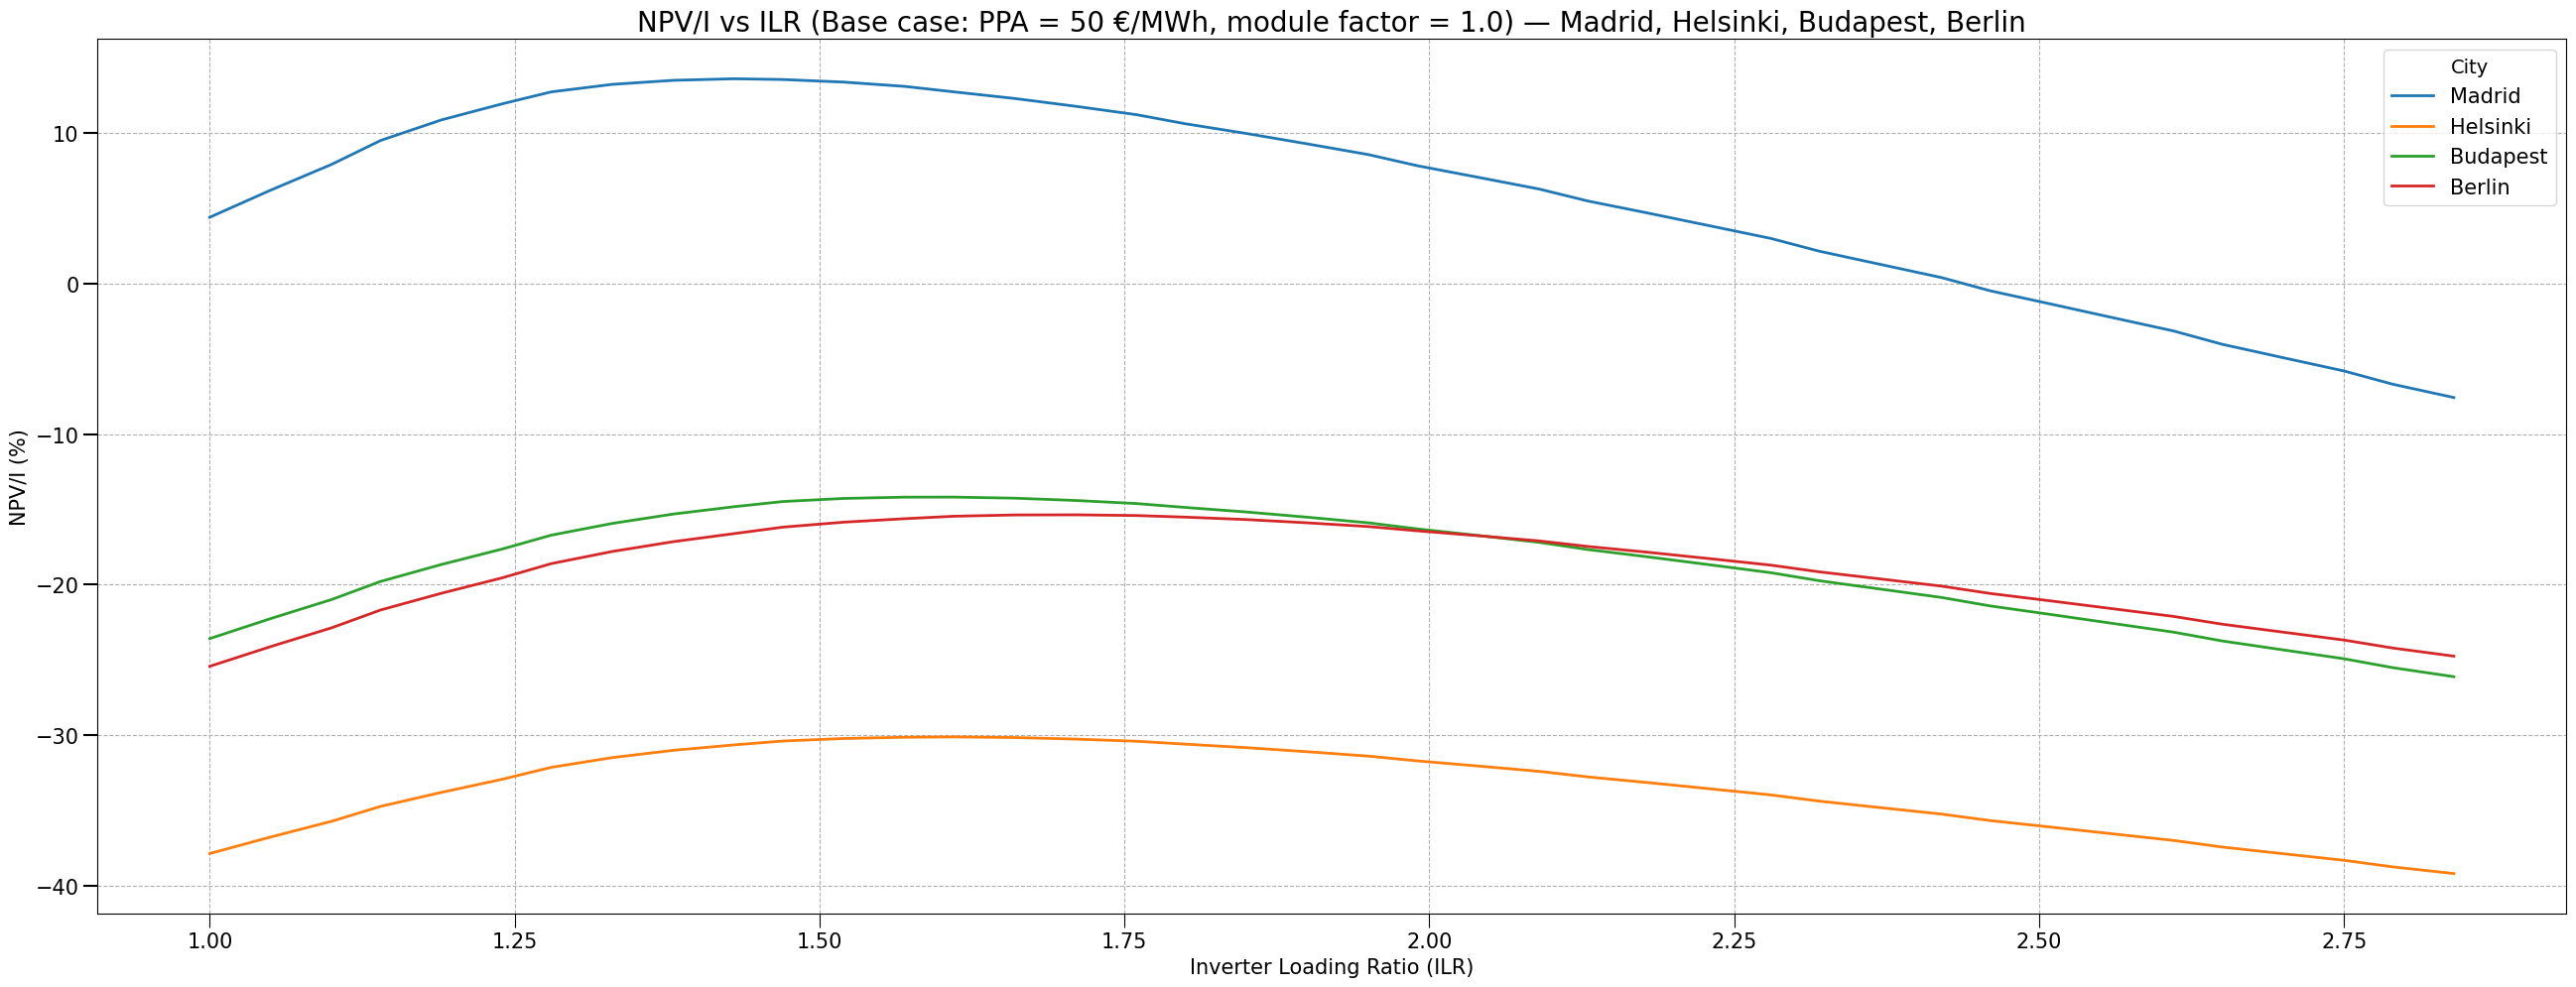

In [4]:
# === NPV/I vs ILR line plot for Madrid, Helsinki, Budapest, and Berlin (base case) ===
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

FIN_CSV = "financial_results_parametric.csv"  # Grid City×ILR×scenario

# 1) Load complete financial results.
df_fin = pd.read_csv(FIN_CSV)

# 2) Ensure expected columns are present and normalize the npv_over_I column name.
need = {"City","ILR","ppa_eur_mwh","module_factor"}
missing = need - set(df_fin.columns)
if missing:
    raise ValueError(f"Faltan columnas en {FIN_CSV}: {sorted(missing)}")

if 'npv_over_I' not in df_fin.columns:
    if 'npv/I' in df_fin.columns:
        df_fin = df_fin.rename(columns={'npv/I': 'npv_over_I'})
    else:
        raise ValueError("No encuentro la columna de NPV/I (esperaba 'npv_over_I' o 'npv/I').")

# 3) Base case (PPA=50 €/MWh, module_factor=1.0)
df_fin_ppa_50 = df_fin[(df_fin['ppa_eur_mwh'] == 50) & (df_fin['module_factor'] == 1.0)].copy()
if df_fin_ppa_50.empty:
    raise ValueError("Escenario base vacío (ppa_eur_mwh=50, module_factor=1.0).")

# 4) City selection
cities = ['Madrid', 'Helsinki', 'Budapest', 'Berlin']
df_fin_ppa_50 = df_fin_ppa_50[df_fin_ppa_50['City'].isin(cities)].copy()

# 5) Style
params = {
    'axes.labelsize': 15,
    'axes.titlesize': 20,
    'font.size': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'ytick.major.width': 1.5,
    'text.usetex': False,
    'figure.figsize': [8, 6]
}
mpl.rcParams.update(params)

# 6) Plot
plt.figure(figsize=(26, 10))

# 7) Plot line for each city (ordered by ILR)
for city in cities:
    df_city = df_fin_ppa_50[df_fin_ppa_50['City'] == city].copy()
    if df_city.empty:
        continue
    df_city = df_city.sort_values('ILR')
    plt.plot(
        df_city['ILR'],
        df_city['npv_over_I'] * 100.0,  # Percentage
        label=city,
        linewidth=2
    )

# 8) labels and aestethics
plt.title('NPV/I vs ILR (Base case: PPA = 50 €/MWh, module factor = 1.0) — Madrid, Helsinki, Budapest, Berlin')
plt.xlabel('Inverter Loading Ratio (ILR)')
plt.ylabel('NPV/I (%)')
plt.grid(axis='both', which='both', linestyle='--')
plt.legend(title='City',title_fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
# === Bubble plot: Optimal ILR vs NPV/I with legend ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


def _scale_sizes(x, smin=80, smax=1200, mode="sqrt"):
    """Scale bubble sizes based on annual energy (MWh)."""
    x = np.asarray(x, dtype=float)
    x = np.where(np.isfinite(x), x, np.nan)
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(xmin) or xmax <= xmin:
        return np.full_like(x, (smin + smax)/2.0)
    if mode == "sqrt":
        x_norm = (np.sqrt(x) - np.sqrt(xmin)) / (np.sqrt(xmax) - np.sqrt(xmin))
    else:
        x_norm = (x - xmin) / (xmax - xmin)
    return smin + x_norm * (smax - smin)

def _energy_legend_handles(e, color='tab:blue', quants=(0.25, 0.5, 0.9),
                           ms_min=9, ms_max=20):
    """Generate handles for a size legend based on energy quantiles."""
    e = np.asarray(e, dtype=float)
    if not np.isfinite(e).any():
        return [], []
    qvals = [np.nanquantile(e, q) for q in quants]
    emin, emax = float(np.nanmin(e)), float(np.nanmax(e))

    def scale_ms(val):
        if not np.isfinite(val) or emax <= emin:
            return (ms_min + ms_max)/2.0
        t = (np.sqrt(val) - np.sqrt(emin)) / (np.sqrt(emax) - np.sqrt(emin))
        return ms_min + t*(ms_max - ms_min)

    handles, labels = [], []
    for v in qvals:
        handles.append(
            Line2D([0],[0], marker='o', color='w', markerfacecolor=color,
                   linestyle='None', markersize=scale_ms(v), alpha=0.65)
        )
        labels.append(f"{int(v):,} MWh".replace(",", " "))
    return handles, labels

def plot_ilr_npv_bubbles_all_labels(df: pd.DataFrame,
                                    title: str | None = None,
                                    label_fontsize: int = 14,
                                    label_alpha: float = 0.95,
                                    offset_pts: float = 3.0,
                                    jitter_pts: float = 6.0,
                                    figsize=(13.5, 7),
                                    width_ratios=(4, 1),
                                    x_tick_step: float = 0.05,   # tick step
                                    x_min: float = 1.0,          # X axis min
                                    x_lim_pad: float = 0.005,    
                                    save: str | None = None):
    """
    df must contain: City, ILR, npv_over_I, AC_energy_MWh.
    """
    need = {"City", "ILR", "npv_over_I", "AC_energy_MWh"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"Faltan columnas en df: {sorted(missing)}")

    if title is None:
        if {"ppa_eur_mwh","module_factor"}.issubset(df.columns):
            title = (f"Optimal ILR vs NPV/I — PPA={df['ppa_eur_mwh'].iloc[0]:.0f} €/MWh, "
                     f"Module factor={df['module_factor'].iloc[0]:g}")
        else:
            title = "Optimal ILR vs NPV/I"

    x = df["ILR"].to_numpy(float)
    y = df["npv_over_I"].to_numpy(float)
    e = df["AC_energy_MWh"].to_numpy(float)
    sizes  = _scale_sizes(e, smin=80, smax=1200, mode="sqrt")
    colors = np.where(y >= 0, "tab:green", "tab:red")

    fig, (ax, ax_leg) = plt.subplots(
        1, 2,
        figsize=figsize,
        constrained_layout=True,
        gridspec_kw={"width_ratios": list(width_ratios)}
    )
    ax_leg.set_axis_off()

    ax.scatter(x, y, s=sizes, c=colors, alpha=0.75,
               edgecolor='white', linewidth=0.6)
    ax.set_xlabel("Optimal ILR")
    ax.set_ylabel("NPV / Initial Investment")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)

    # === X-axis: start at 1.00 with ticks every 0.05. ===
    xmax = float(np.nanmax(x))
    right = np.ceil(xmax / x_tick_step) * x_tick_step
    ax.set_xlim(x_min, right + x_lim_pad)
    ax.xaxis.set_major_locator(MultipleLocator(base=x_tick_step))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Labels for all cities.
    n = len(df)
    angles = np.deg2rad((np.arange(n) * 137.508) % 360.0)
    dx = offset_pts + jitter_pts * np.cos(angles)
    dy = offset_pts + jitter_pts * np.sin(angles)
    for i, row in df.reset_index(drop=True).iterrows():
        ha = "left" if dx[i] >= 0 else "right"
        va = "bottom" if dy[i] >= 0 else "top"
        ax.annotate(row["City"], (x[i], y[i]),
                    xytext=(dx[i], dy[i]), textcoords="offset points",
                    ha=ha, va=va, fontsize=label_fontsize, alpha=label_alpha,
                    path_effects=[pe.withStroke(linewidth=2.5, foreground="white")])

    # Legend
    h_e, l_e = _energy_legend_handles(e, color='tab:blue', quants=(0.25, 0.5, 0.9))
    if h_e:
        leg_energy = ax_leg.legend(h_e, l_e, title="Annual AC energy (MWh) - Year 1",
                                   loc='upper left', frameon=True,
                                   labelspacing=1.1, borderaxespad=0.0)
        ax_leg.add_artist(leg_energy)

    h_c = [
        Line2D([0],[0], marker='o', color='w', markerfacecolor='tab:green',
               markersize=10, linestyle='None', label='NPV/I ≥ 0'),
        Line2D([0],[0], marker='o', color='w', markerfacecolor='tab:red',
               markersize=10, linestyle='None', label='NPV/I < 0'),
    ]
    ax_leg.legend(handles=h_c, loc='lower left', frameon=True,
                  labelspacing=1.1, borderaxespad=0.0)

    if save:
        plt.savefig(save, dpi=150, bbox_inches="tight")
    plt.show()

# --- Examples ---
# df_opt_all   = load_latest_optimal()
# df_opt_base  = filter_scenario(df_opt_all, ppa=50, module_factor=1.0)
# energy_df    = load_energy()
# df_plot_base = attach_energy(df_opt_base, energy_df)
# plot_ilr_npv_bubbles_all_labels(
#     df_plot_base,
#     title="Optimal ILR vs NPV/I — Base (PPA=50, no reduction)",
#     label_fontsize=7,
#     offset_pts=3.0,
#     jitter_pts=6.0,
#     figsize=(14.5, 7),         
#     width_ratios=(4.5, 1.0),   
#     save=None
# )

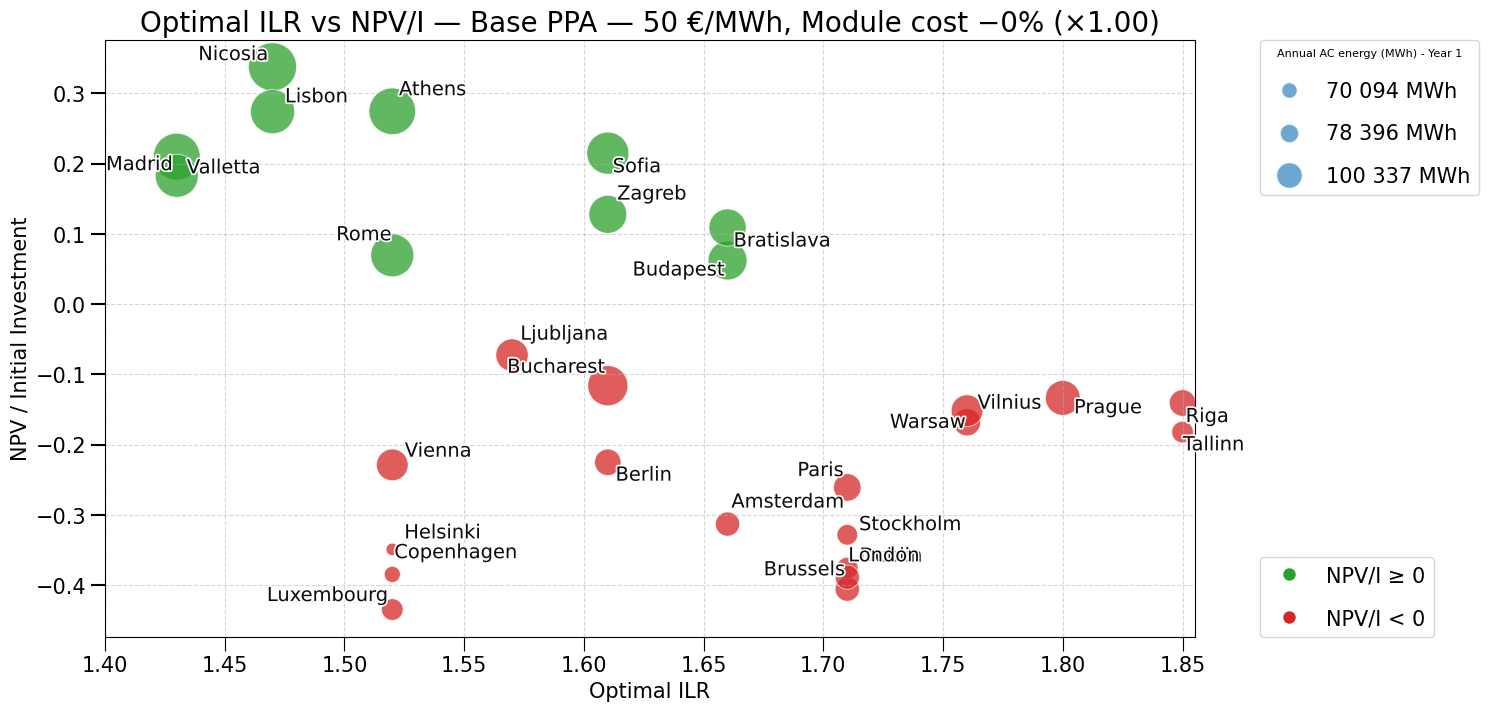

In [6]:
df_opt_all   = load_latest_optimal()
df_opt_base  = filter_scenario(df_opt_all, ppa=50, module_factor=1.0)
energy_df    = load_energy()
df_plot_base = attach_energy(df_opt_base, energy_df)

plot_ilr_npv_bubbles_all_labels(
    df_plot_base,
    title="Optimal ILR vs NPV/I — Base PPA — 50 €/MWh, Module cost −0% (×1.00)",
    x_tick_step=0.05,     # Intervals of 0.05 on the X-axis.
    x_min=1.4,           # eje X starts in 1.00
    figsize=(15, 7),
    width_ratios=(4.5, 1.0)
)

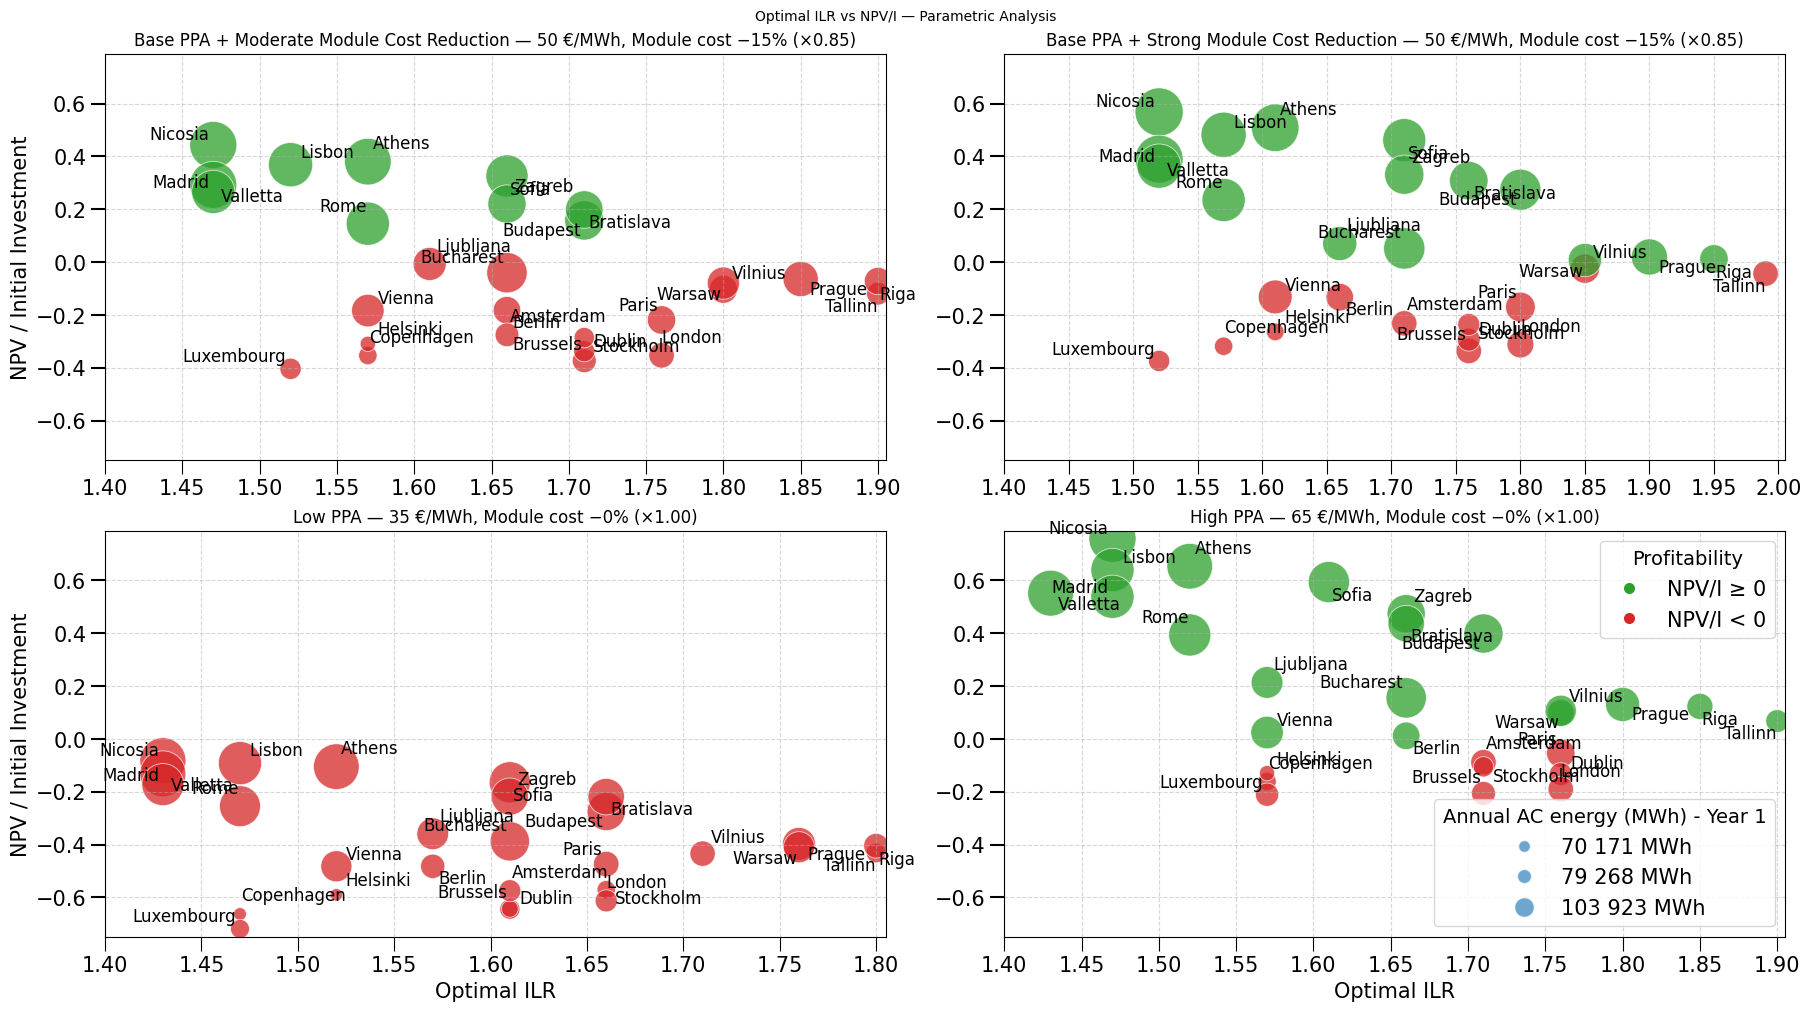

In [7]:
# === 2×2 GRID of scenarios (excluding base and conservative) ===

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

def _plot_bubbles_on_ax(ax, df_plot,
                        x_min=1.4, x_tick_step=0.05, x_pad_right=0.005,
                        sizes_minmax=None, label_fontsize=6, jitter_pts=5, offset_pts=2.0):
    """
    Plot the bubbles on an existing axis, using the same style as plot_ilr_npv_bubbles_all_labels.
    """
    # Data
    x = df_plot["ILR"].to_numpy(float)
    y = df_plot["npv_over_I"].to_numpy(float)
    e = df_plot["AC_energy_MWh"].to_numpy(float)

    # Color per NPV/I sign
    colors = np.where(y >= 0, "tab:green", "tab:red")

    # Sizes should be consistent across subplots if we pass global min/max values.
    if sizes_minmax is not None:
        vmin, vmax = sizes_minmax
        sizes = _scale_sizes(e, smin=80, smax=1200, mode="sqrt") if vmax <= vmin else \
                (80 + (np.sqrt(e) - np.sqrt(vmin)) / (np.sqrt(vmax) - np.sqrt(vmin)) * (1200 - 80))
    else:
        sizes = _scale_sizes(e, smin=80, smax=1200, mode="sqrt")

    ax.scatter(x, y, s=sizes, c=colors, alpha=0.75, edgecolor='white', linewidth=0.6)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Starts at x_min with ticks every 0.05.
    xmax = float(np.nanmax(x))
    right = np.ceil(xmax / x_tick_step) * x_tick_step
    ax.set_xlim(x_min, right + x_pad_right)
    ax.xaxis.set_major_locator(MultipleLocator(base=x_tick_step))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # City labels
    n = len(df_plot)
    angles = np.deg2rad((np.arange(n) * 137.508) % 360.0)
    dx = offset_pts + jitter_pts * np.cos(angles)
    dy = offset_pts + jitter_pts * np.sin(angles)
    for i, row in df_plot.reset_index(drop=True).iterrows():
        ha = "left" if dx[i] >= 0 else "right"
        va = "bottom" if dy[i] >= 0 else "top"
        ax.annotate(row["City"], (x[i], y[i]),
                    xytext=(dx[i], dy[i]), textcoords="offset points",
                    ha=ha, va=va, fontsize=label_fontsize, color="black")

def plot_scenarios_grid_2x2(df_opt_all, energy_df,
                            scenarios,                      # list: (ppa, module, título)
                            x_min=1.4, x_tick_step=0.05,
                            figsize=(18, 10),
                            show_legends=True):
    """
    Plot a 2×2 grid of scenarios. Each scenario is plotted using the same rules as the single-plot function.
    Place the legends (colors and sizes) in the last subplot.
    """
    # Prepare data for each scenario and define ranges
    dfs = []
    all_e = []
    all_y = []

    for ppa, mf, title in scenarios:
        df_opt = filter_scenario(df_opt_all, ppa=ppa, module_factor=mf)
        df_plot = attach_energy(df_opt, energy_df).copy()
        df_plot["__title__"] = title or f"PPA={int(ppa)} €/MWh | Module={mf:g}"
        dfs.append(df_plot)
        all_e.append(df_plot["AC_energy_MWh"].to_numpy(float))
        all_y.append(df_plot["npv_over_I"].to_numpy(float))

    # Rangos globales para que los tamaños y el eje Y sean comparables entre subplots
    e_all = np.concatenate(all_e) if len(all_e) else np.array([1.0])
    y_all = np.concatenate(all_y) if len(all_y) else np.array([0.0])
    e_min, e_max = float(np.nanmin(e_all)), float(np.nanmax(e_all))
    y_min, y_max = float(np.nanmin(y_all)), float(np.nanmax(y_all))
    y_pad = 0.02 * (y_max - y_min + 1e-9)

    fig, axes = plt.subplots(2, 2, figsize=figsize, constrained_layout=True)
    axes = axes.ravel()

    for i, (ax, df_plot) in enumerate(zip(axes, dfs)):
        _plot_bubbles_on_ax(ax, df_plot,
                            x_min=x_min, x_tick_step=x_tick_step,
                            sizes_minmax=(e_min, e_max),
                            label_fontsize=12, jitter_pts=5, offset_pts=2.0)
        ax.set_title(df_plot["__title__"].iloc[0], fontsize=12)
        ax.set_ylim(y_min - y_pad, y_max + y_pad)

        if i in (0, 2):
            ax.set_ylabel("NPV / Initial Investment")
        else:
            ax.set_ylabel("")
        if i in (2, 3):
            ax.set_xlabel("Optimal ILR")
        else:
            ax.set_xlabel("")

    for j in range(len(dfs), 4):
        axes[j].axis("off")

    if show_legends and len(dfs) > 0:
        ax_leg = axes[min(len(dfs)-1, 3)]
        # Colores
        color_handles = [
            Line2D([0],[0], marker='o', color='w', markerfacecolor='tab:green',
                   markersize=9, linestyle='None', label='NPV/I ≥ 0'),
            Line2D([0],[0], marker='o', color='w', markerfacecolor='tab:red',
                   markersize=9, linestyle='None', label='NPV/I < 0'),
        ]
        leg_colors = ax_leg.legend(handles=color_handles, title="Profitability",
                                   loc="upper right", frameon=True,title_fontsize=14)
        ax_leg.add_artist(leg_colors)

        # Sizes (global energy quantiles)
        q = [np.nanquantile(e_all, p) for p in (0.25, 0.5, 0.9)]
        # “Reference” markers (not identical to the plot ones, but proportional)
        ms = np.interp(np.sqrt(q), (np.sqrt(e_min), np.sqrt(e_max)), (7, 15))
        size_handles = [
            Line2D([0],[0], marker='o', color='w', markerfacecolor='tab:blue',
                   markersize=ms[k], linestyle='None', alpha=0.65,
                   label=f"{int(q[k]):,} MWh".replace(",", " "))
            for k in range(3)
        ]
        ax_leg.legend(handles=size_handles, title="Annual AC energy (MWh) - Year 1",
                      loc="lower right", frameon=True,title_fontsize=14)

    fig.suptitle("Optimal ILR vs NPV/I — Parametric Analysis", fontsize=10)
    plt.show()

# ---------------------- Run ----------------------
# 1) Prepare base
df_opt_all   = load_latest_optimal()
energy_df    = load_energy()

# 2) Scenarios
scenarios_2x2 = [
    (50, 0.85, "Base PPA + Moderate Module Cost Reduction — 50 €/MWh, Module cost −15% (×0.85)"),
    (50, 0.70, "Base PPA + Strong Module Cost Reduction — 50 €/MWh, Module cost −15% (×0.85)"),
    (35, 1.0, "Low PPA — 35 €/MWh, Module cost −0% (×1.00)"),
    (65, 1.0, "High PPA — 65 €/MWh, Module cost −0% (×1.00)"),
]

# 3) Plot grid
plot_scenarios_grid_2x2(
    df_opt_all, energy_df,
    scenarios=scenarios_2x2,
    x_min=1.4,          
    x_tick_step=0.05,
    figsize=(18, 10)
)

# df_opt_base  = filter_scenario(df_opt_all, ppa=50, module_factor=1.0)
# df_plot_base = attach_energy(df_opt_base, energy_df)
# plot_ilr_npv_bubbles_all_labels(
#     df_plot_base,
#     title="Optimal ILR vs NPV/I — Base (PPA=50, sin reducción)",
#     x_tick_step=0.05,
#     x_min=1.4,
#     figsize=(15, 7),
#     width_ratios=(4.5, 1.0)
# )

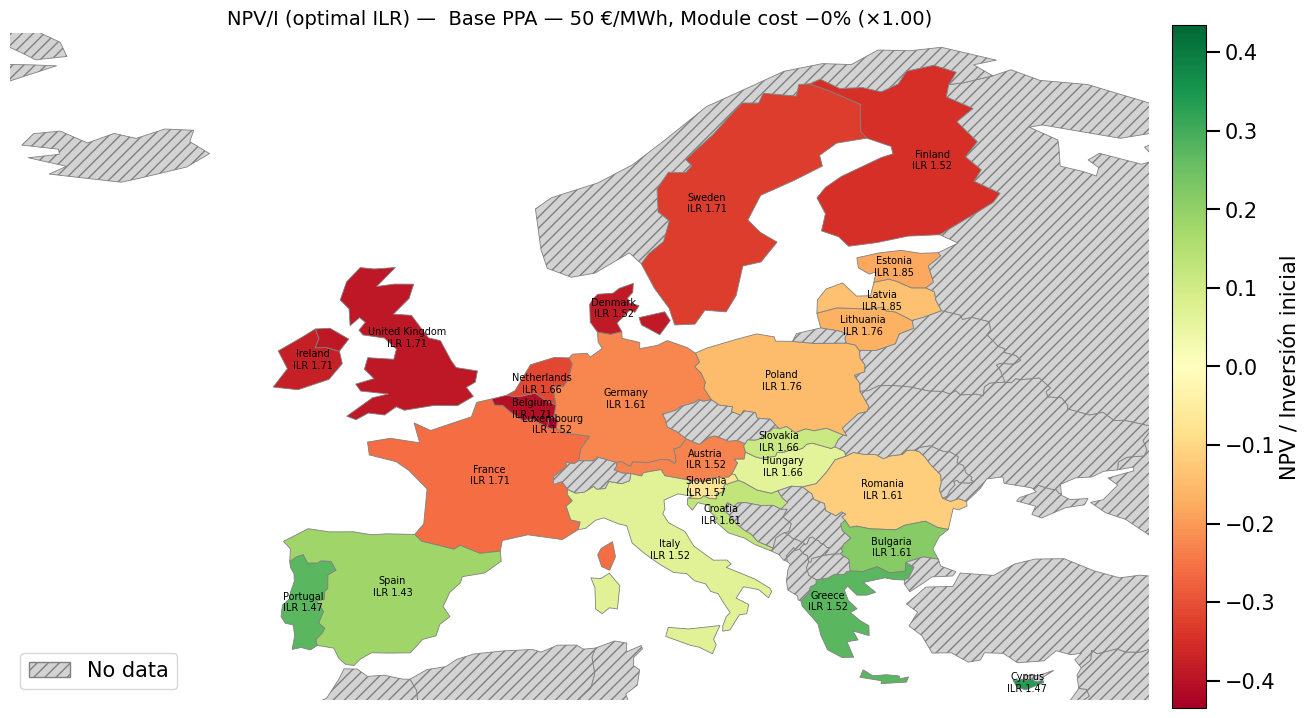

In [8]:
# === NPV/I choropleth by country (green = positive, red = negative) ===
# Requires: geopandas, shapely, fiona
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Patch

OPTIMAL_CSV = "optimal_ilr_by_country_all_scenarios.csv"
NE_COUNTRIES_ZIP = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

# Name fixes (if any don't match Natural Earth)
NAME_FIX = {
    "Czech Republic": "Czechia",
}

def load_world_geodata(url_zip: str = NE_COUNTRIES_ZIP) -> gpd.GeoDataFrame:
    world = gpd.read_file(url_zip)
    # Detect country column name
    for c in ["NAME_EN", "NAME", "ADMIN", "name"]:
        if c in world.columns:
            name_col = c
            break
    else:
        raise RuntimeError(f"No encuentro columna de nombre país en {list(world.columns)}")
    world = world[[name_col, "geometry"]].rename(columns={name_col: "name_join"})
    world = world.set_crs("EPSG:4326")  # asegurar WGS84
    return world

def load_optimal_for_scenario(path=OPTIMAL_CSV, ppa=50, module_factor=1.0) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[(df["ppa_eur_mwh"] == ppa) & (df["module_factor"] == module_factor)].copy()
    if df.empty:
        raise ValueError("No hay filas para ese escenario (revisa ppa y module_factor).")
    df["map_name"] = df["Country"].replace(NAME_FIX)
    return df[["map_name", "Country", "City", "ILR", "npv_over_I"]]

def plot_npv_map(df_opt: pd.DataFrame,
                 title: str | None = None,
                 cmap: str = "RdYlGn",
                 xlim=(-25, 40), ylim=(34, 72),
                 annotate: bool = True):
    """
    df_opt con ['map_name','Country','City','ILR','npv_over_I']
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from matplotlib.colors import TwoSlopeNorm
    from matplotlib.patches import Patch
    from shapely.geometry import box

    world = load_world_geodata(NE_COUNTRIES_ZIP)

    # Merge shapefile with results
    g = world.merge(df_opt, left_on="name_join", right_on="map_name", how="left")

    # Normalization centered at 0 (green = positive, red = negative)
    if g["npv_over_I"].notna().any():
        vmin = float(g["npv_over_I"].min())
        vmax = float(g["npv_over_I"].max())
        vabs = max(abs(vmin), abs(vmax))
    else:
        vabs = 1.0
    norm = TwoSlopeNorm(vmin=-vabs, vcenter=0.0, vmax=vabs)

    fig, ax = plt.subplots(figsize=(13, 7.5), constrained_layout=True)
    g.plot(column="npv_over_I",
           cmap=cmap, norm=norm,
           edgecolor="0.5", linewidth=0.6,
           ax=ax,
           missing_kwds={"color": "lightgrey", "hatch": "///"})

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("NPV / Inversión inicial")

    # Europe zoom
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_axis_off()
    ax.set_title(title or "NPV/I (ILR óptimo) — Base (PPA=50, no reduction)", fontsize=14)

    # === Annotate ILR within the European map frame ===
    if annotate:
        g_ok = g.dropna(subset=["npv_over_I"]).copy()
        if not g_ok.empty:
           # Clip geometries to the map bbox to avoid centroids in overseas territories
            bbox = box(xlim[0], ylim[0], xlim[1], ylim[1])  # WGS84
            g_clip = g_ok.copy()
            g_clip["geom_clip"] = g_clip.geometry.intersection(bbox)
            g_clip["geom_clip"] = g_clip.apply(
                lambda r: r["geom_clip"] if (r["geom_clip"] is not None and not r["geom_clip"].is_empty) else r.geometry,
                axis=1
            )

            # Proyección métrica + punto representativo dentro de la geometría recortada
            g_lab = gpd.GeoDataFrame(g_clip.drop(columns="geometry"),
                                     geometry="geom_clip", crs="EPSG:4326").to_crs(3035)
            rep_proj = g_lab.geometry.representative_point()

            # Volver a WGS84 para anotar en el plot
            rep_wgs84 = gpd.GeoDataFrame(geometry=rep_proj, crs=g_lab.crs).to_crs(4326)

            for (idx, row), pt in zip(g_clip.iterrows(), rep_wgs84.geometry):
                ax.annotate(f"{row['name_join']}\nILR {row['ILR']:.2f}",
                            xy=(pt.x, pt.y), ha="center", va="center",
                            fontsize=7, color="black")

    # Legend “No data”
    missing_patch = Patch(facecolor="lightgrey", hatch="///", edgecolor="0.5", label="No data")
    ax.legend(handles=[missing_patch], loc="lower left", frameon=True)

    return fig, ax

# ===== Example: BASE scenario (PPA=50, no reduction) =====
df_opt_base = load_optimal_for_scenario(OPTIMAL_CSV, ppa=50, module_factor=1.0)
fig, ax = plot_npv_map(
    df_opt_base,
    title="NPV/I (optimal ILR) —  Base PPA — 50 €/MWh, Module cost −0% (×1.00)",
    cmap="RdYlGn",
    xlim=(-25, 40), ylim=(34, 72),
    annotate=True
)
plt.show()

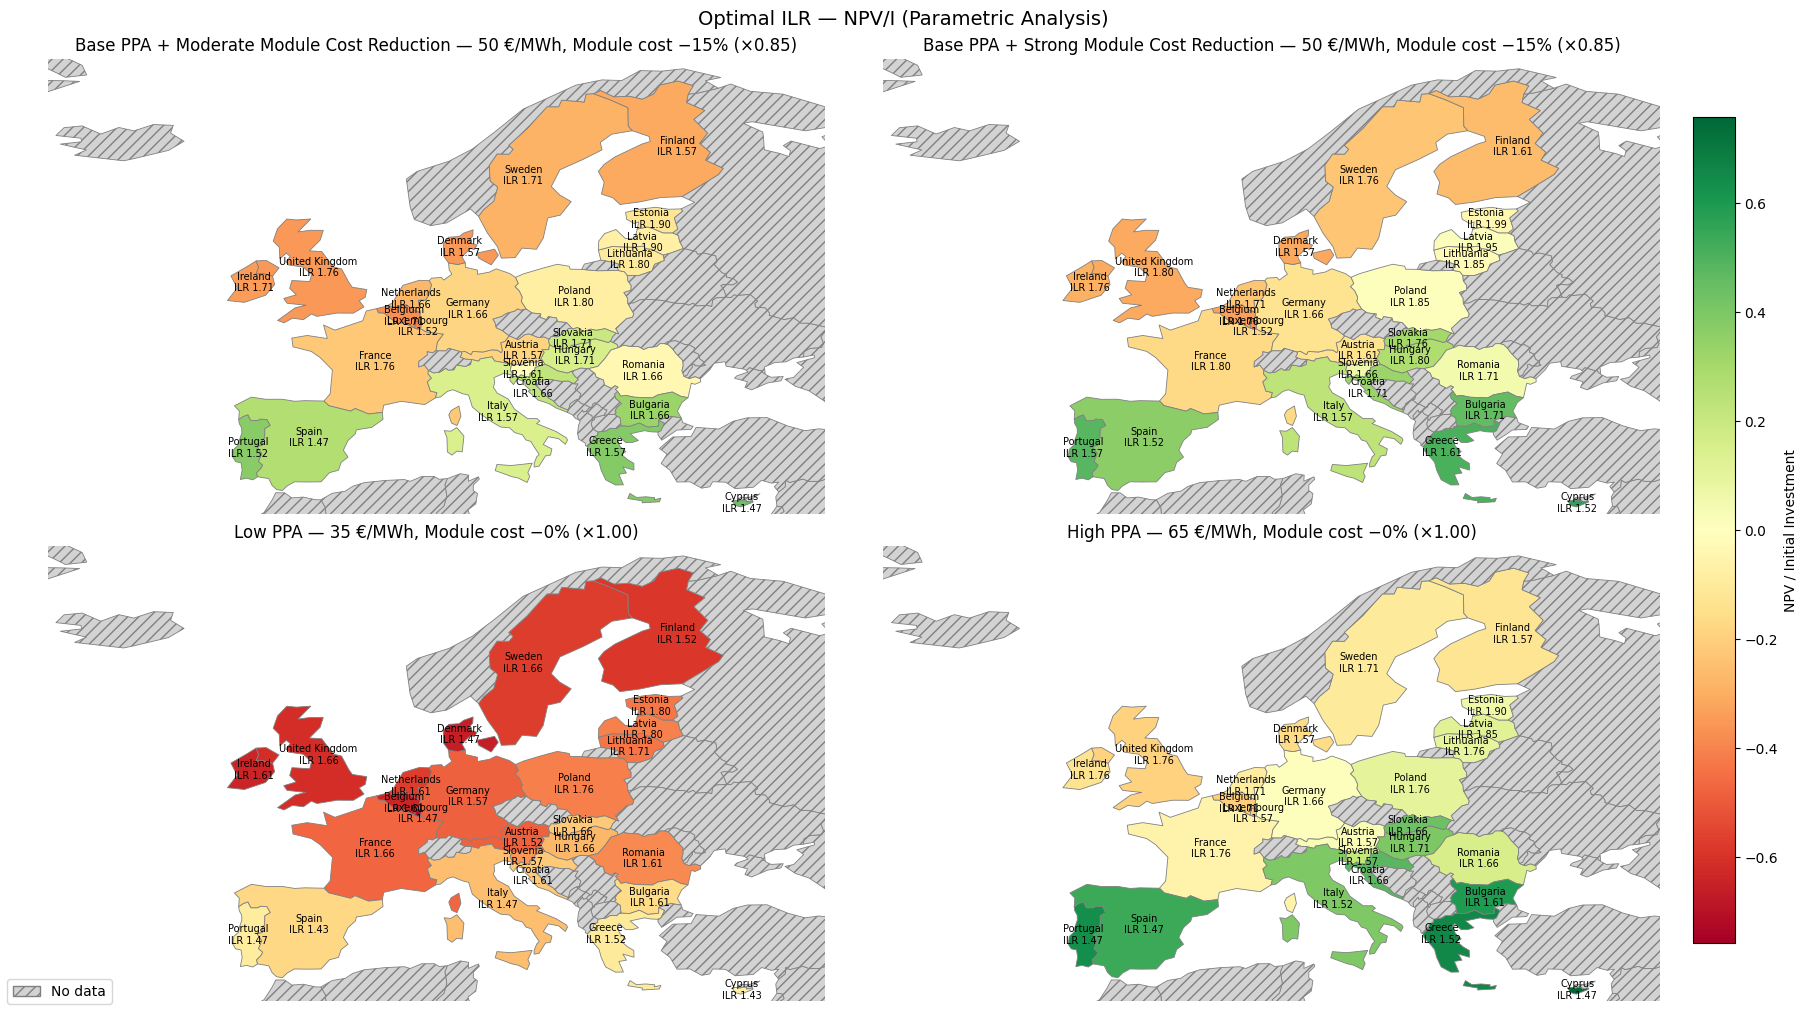

In [7]:
# === 2×2 GRID: NPV/I choropleths by country for parametric scenarios (with country+ILR labels) ===
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from matplotlib.patches import Patch
from shapely.geometry import box

OPTIMAL_CSV = "optimal_ilr_by_country_all_scenarios.csv"
NE_COUNTRIES_ZIP = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"

# Name fixes (if any don't match Natural Earth)
NAME_FIX = {
    "Czech Republic": "Czechia",
}

def load_world_geodata(url_zip: str = NE_COUNTRIES_ZIP) -> gpd.GeoDataFrame:
    world = gpd.read_file(url_zip)
    for c in ["NAME_EN", "NAME", "ADMIN", "name"]:
        if c in world.columns:
            name_col = c
            break
    else:
        raise RuntimeError(f"No encuentro columna de nombre país en {list(world.columns)}")
    world = world[[name_col, "geometry"]].rename(columns={name_col: "name_join"})
    world = world.set_crs("EPSG:4326")
    return world

def load_optimal_for_scenario(path=OPTIMAL_CSV, ppa=50, module_factor=1.0) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[(df["ppa_eur_mwh"] == ppa) & (df["module_factor"] == module_factor)].copy()
    if df.empty:
        raise ValueError(f"No hay filas para el escenario (PPA={ppa}, module_factor={module_factor}).")
    df["map_name"] = df["Country"].replace(NAME_FIX)
    return df[["map_name", "Country", "City", "ILR", "npv_over_I"]]

def _annotate_country_labels(ax, g: gpd.GeoDataFrame, xlim, ylim, fontsize=7):
    """
    Annotate "Country + ILR" using representative_point on the geometry clipped to the map frame (to avoid centroids falling in overseas territories).
    """
    g_ok = g.dropna(subset=["npv_over_I"]).copy()
    if g_ok.empty:
        return
    # # Clip to the map bounding box (WGS84)
    bbox = box(xlim[0], ylim[0], xlim[1], ylim[1])
    g_ok["geom_clip"] = g_ok.geometry.intersection(bbox)
    g_ok["geom_clip"] = g_ok.apply(
        lambda r: r["geom_clip"] if (r["geom_clip"] is not None and not r["geom_clip"].is_empty) else r.geometry,
        axis=1
    )
    # Metric projection and representative point within the clipped polygon
    g_lab = gpd.GeoDataFrame(g_ok.drop(columns="geometry"), geometry="geom_clip", crs="EPSG:4326").to_crs(3035)
    rep_proj = g_lab.geometry.representative_point()
    rep_wgs84 = gpd.GeoDataFrame(geometry=rep_proj, crs=g_lab.crs).to_crs(4326)

    for (idx, row), pt in zip(g_ok.iterrows(), rep_wgs84.geometry):
        ax.annotate(f"{row['name_join']}\nILR {row['ILR']:.2f}",
                    xy=(pt.x, pt.y), ha="center", va="center",
                    fontsize=fontsize, color="black")

def plot_npv_maps_grid(scenarios,
                       world=None,
                       cmap="RdYlGn",
                       xlim=(-25, 40), ylim=(34, 72),
                       annotate=True,
                       figsize=(18, 10),
                       suptitle="Optimal ILR — NPV/I (Parametric Analysis)"):
    """
    scenarios: list of dicts with keys:
      - ppa (float)
      - module (float)
      - title (str)
    """
    if world is None:
        world = load_world_geodata()

    # Load data per scenario and compute global range for normalization
    scen_data, all_vals = [], []
    for sc in scenarios:
        df_opt = load_optimal_for_scenario(OPTIMAL_CSV, ppa=sc["ppa"], module_factor=sc["module"])
        g = world.merge(df_opt, left_on="name_join", right_on="map_name", how="left")
        scen_data.append({"g": g, "title": sc["title"]})
        all_vals.append(g["npv_over_I"])

    all_vals = pd.concat(all_vals)
    if all_vals.notna().any():
        vmin, vmax = float(all_vals.min()), float(all_vals.max())
        vabs = max(abs(vmin), abs(vmax))
    else:
        vabs = 1.0
    norm = TwoSlopeNorm(vmin=-vabs, vcenter=0.0, vmax=vabs)

    fig, axes = plt.subplots(2, 2, figsize=figsize, constrained_layout=True)
    axes = axes.ravel()

    for ax, data in zip(axes, scen_data):
        g = data["g"]
        g.plot(column="npv_over_I",
               cmap=cmap, norm=norm,
               edgecolor="0.5", linewidth=0.6,
               ax=ax,
               missing_kwds={"color": "lightgrey", "hatch": "///"})

        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_axis_off()
        ax.set_title(data["title"], fontsize=12)

        if annotate:
            _annotate_country_labels(ax, g, xlim, ylim, fontsize=7)

    # Hide extra axes if there are fewer than 4 scenarios.
    for j in range(len(scen_data), 4):
        axes[j].axis("off")

    # Global color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.tolist(), fraction=0.025, pad=0.02)
    cbar.set_label("NPV / Initial Investment")

    # Legend “No data”
    missing_patch = Patch(facecolor="lightgrey", hatch="///", edgecolor="0.5", label="No data")
    fig.legend(handles=[missing_patch], loc="lower left", frameon=True)

    fig.suptitle(suptitle, fontsize=14)
    plt.show()

# --------- Scenarios (titles with % reduction). ----------
scenarios_2x2 = [
    {"ppa": 50, "module": 0.85, "title": "Base PPA + Moderate Module Cost Reduction — 50 €/MWh, Module cost −15% (×0.85)"},
    {"ppa": 50, "module": 0.7, "title": "Base PPA + Strong Module Cost Reduction — 50 €/MWh, Module cost −15% (×0.85)"},
    {"ppa": 35, "module": 1.0, "title": "Low PPA — 35 €/MWh, Module cost −0% (×1.00)"},
    {"ppa": 65, "module": 1.0, "title": "High PPA — 65 €/MWh, Module cost −0% (×1.00)"},
]

# --------- Run grid ---------
world = load_world_geodata()
plot_npv_maps_grid(
    scenarios_2x2,
    world=world,
    cmap="RdYlGn",
    xlim=(-25, 40), ylim=(34, 72),
    annotate=True,
    figsize=(18, 10),
    suptitle="Optimal ILR — NPV/I (Parametric Analysis)"
)

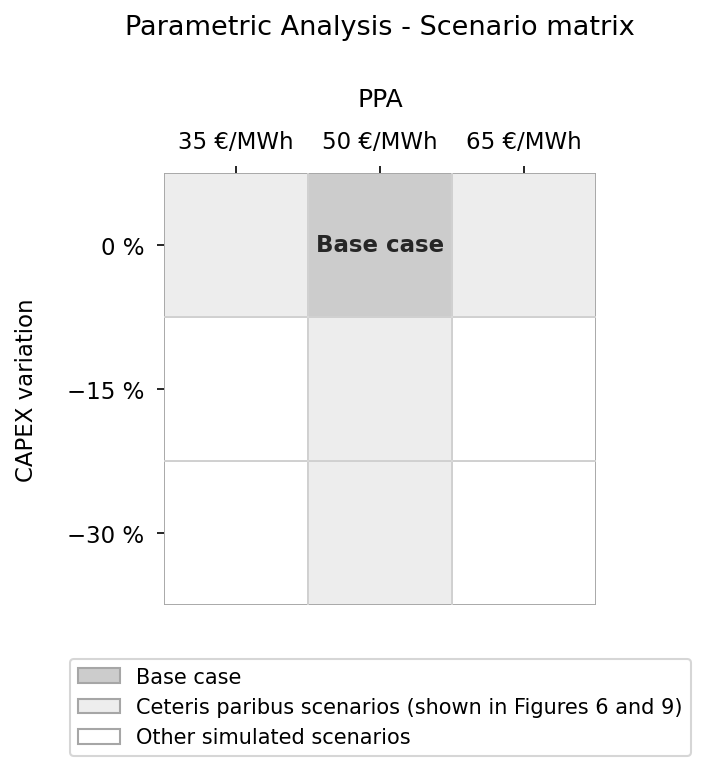

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

# --------------------- Scenario definition ---------------------
PPAs   = ["35 €/MWh", "50 €/MWh", "65 €/MWh"]      # columns (left→right)
CAPEX  = ["−30 %", "−15 %", "0 %"]                 # filas (up→down)

n_cols, n_rows = len(PPAs), len(CAPEX)

# Base Case: PPA=50, CAPEX=0%
base_col, base_row = 1, 2  # (column 1, row 2)

# Ceteris paribus:
#   - vary PPA while keeping CAPEX = 0% (entire base_row)
#   - vary CAPEX while keeping PPA = 50 €/MWh (entire base_col)
ceteris_cells = ({(c, base_row) for c in range(n_cols)}
                 | {(base_col, r) for r in range(n_rows)}) - {(base_col, base_row)}

# --------------------- Style ---------------------
plt.rcParams.update({
    "font.size": 11,
    "axes.edgecolor": "0.25",
    "axes.linewidth": 0.9,
    "figure.dpi": 150
})

# Grey palette
CLR_BORDER   = "0.65"
CLR_GRID     = "0.85"
CLR_BASE     = "0.80"
CLR_CETERIS  = "0.93"
CLR_BG       = "1.00"

fig, ax = plt.subplots(figsize=(8.5, 5.4))

ax.set_xlim(0, n_cols)
ax.set_ylim(0, n_rows)
ax.set_aspect("equal")
ax.spines[:].set_visible(False) 

# base case scenario
for i in range(n_cols):
    for j in range(n_rows):
        ax.add_patch(Rectangle((i, j), 1, 1, facecolor=CLR_BG, ec=CLR_BORDER, lw=0.9))

# ceteris paribus sensitivity analysis
for (i, j) in ceteris_cells:
    ax.add_patch(Rectangle((i, j), 1, 1, facecolor=CLR_CETERIS, ec=CLR_BORDER, lw=0.9))

ax.add_patch(Rectangle((base_col, base_row), 1, 1, facecolor=CLR_BASE, ec=CLR_BORDER, lw=0.9))
ax.text(base_col + 0.5, base_row + 0.5, "Base case", ha="center", va="center",
        fontsize=11, weight="bold", color="0.15")

# Grid lines
for i in range(1, n_cols):
    ax.plot([i, i], [0, n_rows], color=CLR_GRID, lw=0.8)
for j in range(1, n_rows):
    ax.plot([0, n_cols], [j, j], color=CLR_GRID, lw=0.8)

# --------------------- Axis labels (visible and non-overlapping). ---------------------
# Place PPA names as top ticks centered on each column
ax.set_xticks([i + 0.5 for i in range(n_cols)], PPAs)
ax.tick_params(axis="x", top=True, labeltop=True, bottom=False, labelbottom=False, pad=6)

# Place CAPEX variations as left ticks centered on each row
ax.set_yticks([j + 0.5 for j in range(n_rows)], CAPEX)
ax.tick_params(axis="y", left=True, labelleft=True, right=False, labelright=False, pad=6)

# Labels “Axis title”
ax.set_ylabel("CAPEX variation", labelpad=14)
fig.text(0.5, 0.90, "PPA", ha="center", va="top", fontsize=12)

# --------------------- Legend ---------------------
handles = [
    Patch(facecolor=CLR_BASE,    edgecolor=CLR_BORDER, label="Base case"),
    Patch(facecolor=CLR_CETERIS, edgecolor=CLR_BORDER,
          label="Ceteris paribus scenarios (shown in Figures 6 and 9)"),
    Patch(facecolor=CLR_BG,      edgecolor=CLR_BORDER, label="Other simulated scenarios"),
]
ax.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, -0.10),
          ncol=1, frameon=True, fontsize=10)

# --------------------- Title ---------------------
fig.suptitle("Parametric Analysis - Scenario matrix", y=0.99, fontsize=13)

plt.tight_layout(rect=[0.04, 0.02, 0.96, 0.94])
# plt.savefig("scenario_matrix_greyscale_EN.png", dpi=300, bbox_inches="tight")
plt.show()

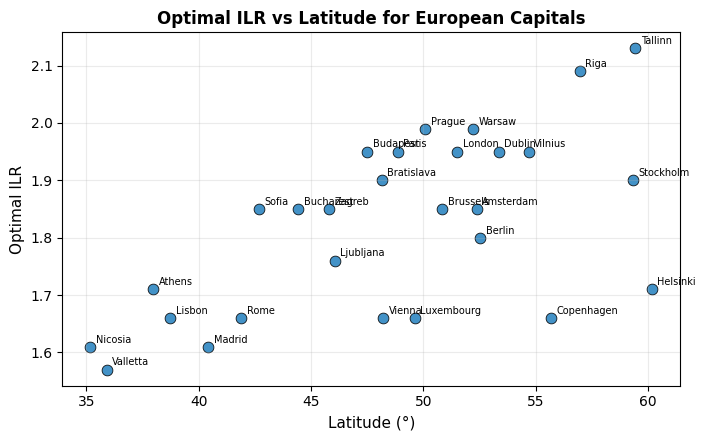

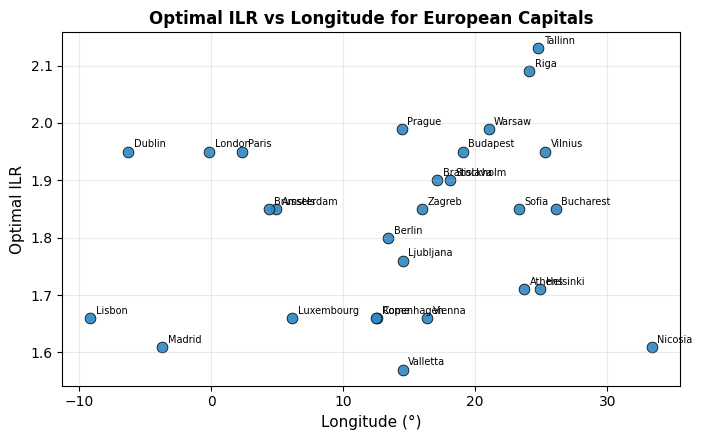

In [5]:
# --- Load optimal data ---
ilr_df = pd.read_csv("optimal_ilr_by_country_all_scenarios.csv")
idx_best = ilr_df.groupby("City")["npv_over_I"].idxmax()
ilr_best = ilr_df.loc[idx_best, ["City", "ILR"]].set_index("City")

# --- Capital cities coordinates ---
d = {
    'city': [
        'Madrid', 'Paris', 'Berlin', 'Rome', 'Vienna', 'Brussels', 'Sofia',
        'Zagreb', 'Nicosia', 'Prague', 'Copenhagen', 'Tallinn', 'Helsinki',
        'Athens', 'Budapest', 'Dublin', 'Riga', 'Vilnius', 'Luxembourg',
        'Valletta', 'Amsterdam', 'Warsaw', 'Lisbon', 'Bucharest', 'Bratislava',
        'Ljubljana', 'Stockholm', 'London'
    ],
    'latitude': [
        40.4165, 48.85341, 52.52281, 41.89306, 48.2082, 50.8503, 42.6977,
        45.815, 35.1856, 50.0755, 55.6761, 59.437, 60.1699, 37.9838, 47.4979,
        53.3498, 56.9496, 54.6872, 49.6116, 35.8989, 52.3676, 52.2297,
        38.7223, 44.4268, 48.1486, 46.0569, 59.3293, 51.5074
    ],
    'longitude': [
        -3.70256, 2.3488, 13.408176, 12.48278, 16.3738, 4.3517, 23.3219,
        15.9819, 33.3823, 14.4378, 12.5683, 24.7536, 24.9384, 23.7275,
        19.0402, -6.2603, 24.1052, 25.2797, 6.1319, 14.5146, 4.9041,
        21.0122, -9.1393, 26.1025, 17.1077, 14.5058, 18.0686, -0.1278
    ]
}
coord_df = pd.DataFrame(d).set_index("city")

coord_df.index = coord_df.index.str.strip()
ilr_best.index = ilr_best.index.str.strip()
data = ilr_best.join(coord_df, how="inner").reset_index().rename(columns={"index": "City"})

# --- auxiliary functions ---
def plot_ilr_scatter(df, xcol, xlabel, title):
    plt.figure(figsize=(7, 4.5))
    plt.scatter(df[xcol], df["ILR"], s=60, color="#2E86C1",
                edgecolor="black", linewidth=0.6, alpha=0.9)
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel("Optimal ILR", fontsize=11)
    plt.title(title, fontsize=12, weight="bold")
    plt.grid(alpha=0.25)
    plt.tight_layout()

    # labels with city names
    for _, row in df.iterrows():
        plt.annotate(row["City"], (row[xcol], row["ILR"]),
                     textcoords="offset points", xytext=(4, 3), fontsize=7)
    plt.show()

# --- 1) ILR vs Latitude ---
plot_ilr_scatter(
    data,
    xcol="latitude",
    xlabel="Latitude (°)",
    title="Optimal ILR vs Latitude for European Capitals"
)

# --- 2) ILR vs Longitude ---
plot_ilr_scatter(
    data,
    xcol="longitude",
    xlabel="Longitude (°)",
    title="Optimal ILR vs Longitude for European Capitals"
)
